
  # import torch library

In [65]:
import os
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from timeit import default_timer as timer

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import resnet18, ResNet18_Weights
from torch.optim import lr_scheduler
from torchinfo import summary
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Transform
# convert data to tensor and Data augmentation

In [66]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load Data

In [67]:
import os
from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.7),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load data
data_dir = "/kaggle/input/chest-ctscan-images/Data"
train_data = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=data_transform)
test_data = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=data_transform)
validation_data = datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=data_transform)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")
print(f"Number of validation samples: {len(validation_data)}")

Number of training samples: 613
Number of test samples: 315
Number of validation samples: 72


In [68]:
train_data[np.random.randint(0 , len(train_data))]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

In [69]:
len(train_data)  , len(test_data)

(613, 315)

In [70]:
class_names = train_data.classes
class_names

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [71]:
class_dict = train_data.class_to_idx
class_dict

{'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1,
 'normal': 2,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}

In [72]:
# Change the key
old_key1 = 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
new_key1 = 'adenocarcinoma_left.lower.lobe'

old_key2 = 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
new_key2 = 'large.cell.carcinoma_left.hilum'

old_key3 = 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'
new_key3 = 'squamous.cell.carcinoma_left.hilum'

# Step 1: Add new key-value pair
class_dict[new_key1] = class_dict[old_key1]
class_dict[new_key2] = class_dict[old_key2]
class_dict[new_key3] = class_dict[old_key3]


# Step 2: Remove old key-value pair
del class_dict[old_key1]
del class_dict[old_key2]
del class_dict[old_key3]


print(class_dict)





{'normal': 2, 'adenocarcinoma_left.lower.lobe': 0, 'large.cell.carcinoma_left.hilum': 1, 'squamous.cell.carcinoma_left.hilum': 3}


In [73]:
class_names[0]=new_key1
class_names[1]=new_key2
class_names[3]=new_key3
class_names

['adenocarcinoma_left.lower.lobe',
 'large.cell.carcinoma_left.hilum',
 'normal',
 'squamous.cell.carcinoma_left.hilum']

In [74]:
len(train_data), len(test_data)

(613, 315)

In [75]:
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
img, label = train_data[random_idx][0], train_data[random_idx][1]

print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")
print(f"class name: {class_names[label]}")

Image tensor:
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
Image shape: torch.Size([3, 224, 224])
Image datatype: torch.float32
Image label: 1
Label datatype: <class 'int'>
class name: large.cell.carcinoma_left.hilum


# Visualize

Image permute: torch.Size([224, 224, 3]) 


Text(0.5, 1.0, 'adenocarcinoma_left.lower.lobe')

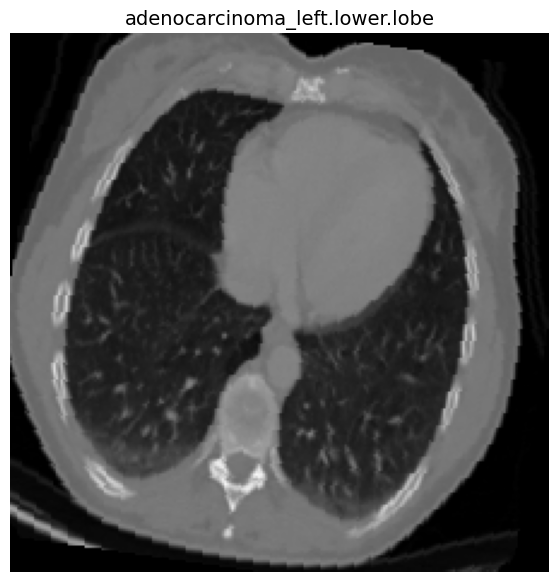

In [76]:
import random 
from PIL import Image
import matplotlib.pyplot as plt
random_idx = torch.randint(0, len(train_data), size=(1,)).item()
img, label = train_data[random_idx][0], train_data[random_idx][1]


img_permute = img.permute(1, 2, 0)
print(f"Image permute: {img_permute.shape} ")
plt.figure(figsize=(12, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

# Dataloaders

In [77]:
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ca6cb2df7d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ca6dd538510>)

# Build Model

In [78]:
resnet18_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for param in resnet18_model.parameters():
    param.requires_grad = True

resnet18_model.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, len(class_names))
)

resnet18_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Loss and optimizer

In [79]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Model summary

In [80]:

summary(resnet18_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 4]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

# Train Step

In [81]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (y_pred.argmax(1) == y).sum().item() / len(y)

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [82]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

            total_loss += loss.item()
            total_acc += (y_pred.argmax(1) == y).sum().item() / len(y)

    return total_loss / len(dataloader), total_acc / len(dataloader)

In [83]:
def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device):
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

# Train model

In [84]:

NUM_EPOCHS = 15
start_time = timer()
model_0_results = train(resnet18_model, train_dataloader, test_dataloader, optimizer, loss_fn, NUM_EPOCHS, device)
end_time = timer()

print(f"Total training time: {end_time - start_time:.2f} seconds")
print(f"Final train loss: {model_0_results['train_loss'][-1]:.4f}, train acc: {model_0_results['train_acc'][-1]:.4f}")
print(f"Final test loss: {model_0_results['test_loss'][-1]:.4f}, test acc: {model_0_results['test_acc'][-1]:.4f}")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Train loss: 1.2651 | Train acc: 0.4284 | Test loss: 1.0653 | Test acc: 0.5632
Epoch 2/15 | Train loss: 0.8472 | Train acc: 0.6253 | Test loss: 1.2312 | Test acc: 0.4177
Epoch 3/15 | Train loss: 0.6142 | Train acc: 0.7497 | Test loss: 1.9836 | Test acc: 0.3719
Epoch 4/15 | Train loss: 0.4320 | Train acc: 0.8453 | Test loss: 0.9622 | Test acc: 0.5706
Epoch 5/15 | Train loss: 0.2345 | Train acc: 0.9181 | Test loss: 0.4947 | Test acc: 0.7883
Epoch 6/15 | Train loss: 0.2938 | Train acc: 0.8984 | Test loss: 1.2721 | Test acc: 0.4841
Epoch 7/15 | Train loss: 0.2015 | Train acc: 0.9313 | Test loss: 0.6740 | Test acc: 0.7447
Epoch 8/15 | Train loss: 0.1241 | Train acc: 0.9594 | Test loss: 0.3692 | Test acc: 0.8553
Epoch 9/15 | Train loss: 0.0701 | Train acc: 0.9766 | Test loss: 0.3941 | Test acc: 0.8704
Epoch 10/15 | Train loss: 0.0471 | Train acc: 0.9844 | Test loss: 0.3219 | Test acc: 0.8684
Epoch 11/15 | Train loss: 0.0461 | Train acc: 0.9859 | Test loss: 0.3699 | Test acc: 0.87

In [85]:
torch.save(resnet18_model.state_dict(), "resnet18_chestct.pth")
